## Combine the Survey datasets

There are two batches of ratings as the first was more of a test how MTurk works

The image order was scrambled for each image so the order has less of an effect on ratings, therefore it needs to be
unscrambled.

Furthermore unapproved ratings (like ones containing only default values) need to be filtered out

In [2]:
import pandas as pd
import numpy as np
from sympy import true
import survey_utils as utils
import random
import os
import math

from pathlib import Path
from IPython.core.display import display, HTML
import scipy

plotpath = Path('results/surveyplots')

print(f"Scipy version is: {scipy.__version__}, needs to be 1.7.0 or greater")

print(os.path.abspath(os.curdir))

# Enables visualizations
visualization = True
relevant_columns = utils.get_relevant_columns_for_visualization(visualization)

# styles to evaluate further
styles = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']

# Load the datasets from both batches
survey1 = pd.read_csv(Path('sets/survey_results/processed/MTurk_Batch_1_approvals.csv'))
survey2 = pd.read_csv(Path('sets/survey_results/processed/MTurk_Batch_2_approvals.csv'))

survey_comb = pd.concat([survey1, survey2], sort=False, ignore_index=True)

# Combine the 2 suvey datasets and descramble ratings.
survey_result = utils.preprocess_data(survey1, survey2, visualization)

print('Done!')

Scipy version is: 1.7.0, needs to be 1.7.0 or greater
C:\Users\Chaotika\Documents\GitHub\NICER\analysis
Done!


## Stats

In [3]:
from dateutil.parser import parse

print(f"In total {survey_comb.shape[0]} tasks were submitted, of which {survey_result.shape[0]} were valid submissions, meaning {survey_comb.shape[0] - survey_result.shape[0]} task submissions were invalid.")

workers = set()
for i in range(survey_comb.shape[0]):
    workers.add(survey_comb.at[i, 'WorkerId'])
print(f"How many participants: {len(workers)}")

submitted = []
for worker in workers:
    worker_task = survey_comb[survey_comb['WorkerId'] == worker]
    submitted.append(worker_task.shape[0])

print(f"On average, each worker submitted {'{:.2f}'.format(np.mean(submitted))} tasks.")

for i in range(survey_comb.shape[0]):
    start = parse(survey_comb.at[i, 'AcceptTime'])
    end = parse(survey_comb.at[i, 'SubmitTime'])
    survey_comb.at[i, 'duration'] = (end - start).total_seconds()

print(f"On average, a worker needed {'{:.2f}'.format(np.mean(survey_comb['duration']))} seconds to complete one of our tasks.")

invalid = survey_comb[survey_comb['Approve'] != 'x']
invalid_workers = set()
for i, row in invalid.iterrows():
    invalid_workers.add(row['WorkerId'])

print(f"How many workers submitted the {invalid.shape[0]} invalid answers? {len(invalid_workers)}")

valid_percentages = []
tasks_from_invalid = []
invalid_task_amounts = []
amount_of_invalid = []
for worker in invalid_workers:
    tasks = survey_comb[survey_comb['WorkerId'] == worker]
    invalid_tasks = invalid[invalid['WorkerId'] == worker]
    tasks_from_invalid.append(tasks.shape[0])
    amount_of_invalid.append(invalid_tasks.shape[0])
    valid_percentages.append(invalid_tasks.shape[0]/tasks.shape[0])

print(f"Of the on avarage {'{:.2f}'.format(np.mean(tasks_from_invalid))} tasks these {len(invalid_workers)} workers submitted, on average {'{:.2%}'.format(np.mean(valid_percentages))}, or {'{:.2f}'.format(np.mean(amount_of_invalid))} were invalid")

print(f"On avarage, invalid tasks needed {'{:.2f}'.format(np.mean(invalid['duration']))} seconds to complete.")

amount_of_ratings = []
for img in survey_result['image_id']:
    image_ratings = survey_result[survey_result['image_id'] == img]
    amount_of_ratings.append(image_ratings.shape[0])

print(np.min(amount_of_ratings))

print(np.mean(amount_of_ratings))

'''
most_submits = survey_comb[survey_comb['WorkerId'] == 'A2MSJRDUC5X680']
display(most_submits)

most_submits_invalid = invalid[invalid['WorkerId'] == 'A2MSJRDUC5X680']
display(most_submits_invalid)
'''

In total 5000 tasks were submitted, of which 4597 were valid submissions, meaning 403 task submissions were invalid.
How many participants: 330
On average, each worker submitted 15.15 tasks.
On average, a worker needed 438.43 seconds to complete one of our tasks.
How many workers submitted the 403 invalid answers? 71
Of the on avarage 34.90 tasks these 71 workers submitted, on average 17.87%, or 5.68 were invalid
On avarage, invalid tasks needed 486.64 seconds to complete.
7
9.257124211442244


C:\Users\Chaotika\anaconda3\envs\scipy\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


"\nmost_submits = survey_comb[survey_comb['WorkerId'] == 'A2MSJRDUC5X680']\ndisplay(most_submits)\n\nmost_submits_invalid = invalid[invalid['WorkerId'] == 'A2MSJRDUC5X680']\ndisplay(most_submits_invalid)\n"

## Graphs for Stats


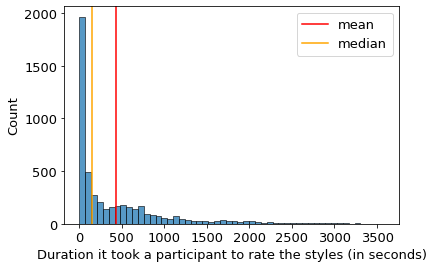

mean amount of duration: 438.4332
median amount of duration: 149.0
mean amount of submissions per participant: 15.151515151515152
median amount of submissions per participant: 6.0


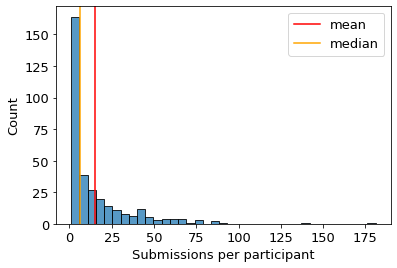

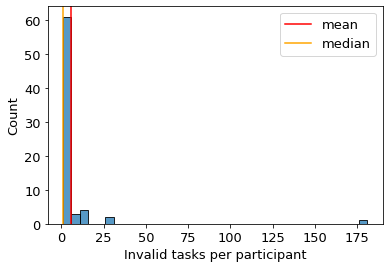

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 13})

g = sns.histplot(data=survey_comb,
                 x='duration',
                 )
plt.axvline(np.mean(survey_comb["duration"]), color='red', label='mean')
plt.axvline(np.median(survey_comb["duration"]), color='orange', label='median')
plt.legend()
g.set(xlabel="Duration it took a participant to rate the styles (in seconds)")

plt.savefig(plotpath / 'duration.svg')
plt.show()

print(f"mean amount of duration: {np.mean(survey_comb['duration'])}")
print(f"median amount of duration: {np.median(survey_comb['duration'])}")

g = sns.histplot(data=submitted,
                 )
plt.axvline(np.mean(submitted), color='red', label='mean')
plt.axvline(np.median(submitted), color='orange', label='median')
plt.legend()

g.set(xlabel="Submissions per participant")

plt.savefig(plotpath / 'sub_per_paticipant.svg')
plt.show()

print(f"mean amount of submissions per participant: {np.mean(submitted)}")
print(f"median amount of submissions per participant: {np.median(submitted)}")

g = sns.histplot(data=amount_of_invalid,
                 binwidth=5
                 )
plt.axvline(np.mean(amount_of_invalid), color='red', label='mean')
plt.axvline(np.median(amount_of_invalid), color='orange', label='median')
plt.legend()

g.set(xlabel="Invalid tasks per participant")

#plt.savefig(plotpath / 'sub_per_paticipant.svg')
plt.show()

## How often is a style the preffered style?

In [5]:
import itertools
styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))

best_count = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)
best_percent = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

for pair in pairs_to_evaluate:
    best_counted = utils.count_best(survey_result, pair, visualization=False)
    best_count.at[pair[0], pair[1]] = best_counted[pair[0]]
    best_count.at[pair[1], pair[0]] = best_counted[pair[1]]
    best_percent.at[pair[0], pair[1]] = best_counted[pair[0]] / (best_counted[pair[0]] + best_counted[pair[1]])
    best_percent.at[pair[1], pair[0]] = best_counted[pair[1]] / (best_counted[pair[0]] + best_counted[pair[1]])

#best_count.prefered_in = best_count.prefered_in.astype(int)
display(best_count)
display(best_percent)

print(best_count.to_latex())

,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,1968,2143,2299,1225
nicer,2526,NaN,2526,2583,1575
ssmtpiaa_sgd,2299,1963,NaN,2314,1242
ssmtpiaa_cma,2158,1919,2153,NaN,1262
expert,3285,2945,3269,3263,NaN


,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,0.437917,0.48244,0.515818,0.271619
nicer,0.562083,NaN,0.562709,0.573745,0.348451
ssmtpiaa_sgd,0.51756,0.437291,NaN,0.518021,0.275327
ssmtpiaa_cma,0.484182,0.426255,0.481979,NaN,0.278895
expert,0.728381,0.651549,0.724673,0.721105,NaN


\begin{tabular}{llllll}
\toprule
{} & original & nicer & ssmtpiaa\_sgd & ssmtpiaa\_cma & expert \\
\midrule
original     &      NaN &  1968 &         2143 &         2299 &   1225 \\
nicer        &     2526 &   NaN &         2526 &         2583 &   1575 \\
ssmtpiaa\_sgd &     2299 &  1963 &          NaN &         2314 &   1242 \\
ssmtpiaa\_cma &     2158 &  1919 &         2153 &          NaN &   1262 \\
expert       &     3285 &  2945 &         3269 &         3263 &    NaN \\
\bottomrule
\end{tabular}



## Significance test

In [6]:
import scipy.stats as stats


significance_level = 0.05
n = survey_result.shape[0]
p = 0.5
correction = 'Sidak'

styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))
results_significance = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

m = (len(styles_to_evaluate) * len(styles_to_evaluate)) / 2 - len(styles_to_evaluate) / 2
if correction == 'Bonferroni':
    corrected_significance_level = significance_level / m
elif correction == 'Sidak':
    corrected_significance_level = 1-(1-significance_level) ** (1/m)
else:
    correction = 'Un'
    corrected_significance_level = significance_level


print(f"{correction} corrected significance level is {'{:.2%}'.format(corrected_significance_level)} with m of {m}")

for pair in pairs_to_evaluate:
    for pair_perm in itertools.permutations(pair):
        base_style, enhanced_style = pair_perm[0], pair_perm[1]
        even_correction = 0
        enhanced_is_better = []
        for i in range(survey_result.shape[0]):
            iter = 0
            best = 0
            # Get best rating for each image
            for style in [base_style, enhanced_style]:
                best = max(best, survey_result.at[i, f'{style}_rating'])
            # Find out to which style it belongs
            if survey_result.at[i, f'{enhanced_style}_rating'] == best:
                if not survey_result.at[i, f'{base_style}_rating'] == best:
                    enhanced_is_better.append(1)
                else:
                    even_correction += 1

        k = len(enhanced_is_better)
        results_significance.at[enhanced_style, base_style] = stats.binomtest(k, n-even_correction, p, alternative='greater')

print(f"Read: [row name] is better than [column name] in [value] of cases to significance level of " + "{:.1%}".format(significance_level))
display(HTML(results_significance.to_html(escape=False)))

'''
results_percentage = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

for pair in pairs_to_evaluate:
    best_counted = utils.count_best(survey_result, pair, visualization=False)

    best_count = pd.DataFrame(index=pair)
    total = 0
    for style in pair:
        total += best_counted[f"{style}"]
    for style in pair:
        best_count.at[style, 'prefered_in'] = "{:.2%}".format(best_counted[f"{style}"] /total)
    str = f"{best_count.at[pair[0], 'prefered_in']} (max p-value: {results_significance.at[pair[0], pair[1]]})"
    results_percentage.at[pair[0], pair[1]] = str
    str = f"{best_count.at[pair[1], 'prefered_in']} (max p-value: {results_significance.at[pair[1], pair[0]]})"
    results_percentage.at[pair[1], pair[0]] = str

display(results_percentage)
print(results_percentage.to_latex())
'''

Sidak corrected significance level is 0.51% with m of 10.0
Read: [row name] is better than [column name] in [value] of cases to significance level of 5.0%


,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,"BinomTestResult(k=1968, n=4494, alternative='greater', proportion_estimate=0.4379172229639519, pvalue=1.0)","BinomTestResult(k=2143, n=4442, alternative='greater', proportion_estimate=0.48244034218820353, pvalue=0.9907597861900949)","BinomTestResult(k=2299, n=4457, alternative='greater', proportion_estimate=0.5158178146735473, pvalue=0.017989119716095032)","BinomTestResult(k=1225, n=4510, alternative='greater', proportion_estimate=0.27161862527716185, pvalue=1.0)"
nicer,"BinomTestResult(k=2526, n=4494, alternative='greater', proportion_estimate=0.562082777036048, pvalue=4.422435623977662e-17)",NaN,"BinomTestResult(k=2526, n=4489, alternative='greater', proportion_estimate=0.562708843840499, pvalue=2.2529906726061346e-17)","BinomTestResult(k=2583, n=4502, alternative='greater', proportion_estimate=0.573745002221235, pvalue=2.101452673922368e-23)","BinomTestResult(k=1575, n=4520, alternative='greater', proportion_estimate=0.34845132743362833, pvalue=1.0)"
ssmtpiaa_sgd,"BinomTestResult(k=2299, n=4442, alternative='greater', proportion_estimate=0.5175596578117965, pvalue=0.010013755759379116)","BinomTestResult(k=1963, n=4489, alternative='greater', proportion_estimate=0.437291156159501, pvalue=1.0)",NaN,"BinomTestResult(k=2314, n=4467, alternative='greater', proportion_estimate=0.518021043205731, pvalue=0.008329593136704892)","BinomTestResult(k=1242, n=4511, alternative='greater', proportion_estimate=0.2753269784970073, pvalue=1.0)"
ssmtpiaa_cma,"BinomTestResult(k=2158, n=4457, alternative='greater', proportion_estimate=0.4841821853264528, pvalue=0.983295687642536)","BinomTestResult(k=1919, n=4502, alternative='greater', proportion_estimate=0.42625499777876497, pvalue=1.0)","BinomTestResult(k=2153, n=4467, alternative='greater', proportion_estimate=0.4819789567942691, pvalue=0.9923263410581076)",NaN,"BinomTestResult(k=1262, n=4525, alternative='greater', proportion_estimate=0.2788950276243094, pvalue=1.0)"
expert,"BinomTestResult(k=3285, n=4510, alternative='greater', proportion_estimate=0.7283813747228381, pvalue=1.7122206467455995e-214)","BinomTestResult(k=2945, n=4520, alternative='greater', proportion_estimate=0.6515486725663717, pvalue=6.667599897698183e-94)","BinomTestResult(k=3269, n=4511, alternative='greater', proportion_estimate=0.7246730215029927, pvalue=1.9411567802748004e-207)","BinomTestResult(k=3263, n=4525, alternative='greater', proportion_estimate=0.7211049723756906, pvalue=2.384453784815084e-201)",NaN


'\nresults_percentage = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)\n\nfor pair in pairs_to_evaluate:\n    best_counted = utils.count_best(survey_result, pair, visualization=False)\n\n    best_count = pd.DataFrame(index=pair)\n    total = 0\n    for style in pair:\n        total += best_counted[f"{style}"]\n    for style in pair:\n        best_count.at[style, \'prefered_in\'] = "{:.2%}".format(best_counted[f"{style}"] /total)\n    str = f"{best_count.at[pair[0], \'prefered_in\']} (max p-value: {results_significance.at[pair[0], pair[1]]})"\n    results_percentage.at[pair[0], pair[1]] = str\n    str = f"{best_count.at[pair[1], \'prefered_in\']} (max p-value: {results_significance.at[pair[1], pair[0]]})"\n    results_percentage.at[pair[1], pair[0]] = str\n\ndisplay(results_percentage)\nprint(results_percentage.to_latex())\n'

## Wilcoxon signed rank test

In [7]:
significance_level = 0.05
n = survey_result.shape[0]
styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))
results_wilcoxon = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

m = (len(styles_to_evaluate) * len(styles_to_evaluate)) / 2 - len(styles_to_evaluate) / 2
if correction == 'Bonferroni':
    corrected_significance_level = significance_level / m
elif correction == 'Sidak':
    corrected_significance_level = 1-(1-significance_level) ** (1/m)
else:
    correction = 'Un'
    corrected_significance_level = significance_level


print(f"{correction} corrected significance level is {'{:.2%}'.format(corrected_significance_level)} with m of {m}")

for pair in pairs_to_evaluate:
    for pair_perm in itertools.permutations(pair):
        base_style, enhanced_style = pair_perm[0], pair_perm[1]

        x = survey_result[f'{enhanced_style}_rating']
        y = survey_result[f'{base_style}_rating']

        p_value = stats.wilcoxon(x, y, alternative='greater')[1]
        results_wilcoxon.at[enhanced_style, base_style] = f'{"{:.2%}".format(p_value)} {p_value < significance_level / m}'

print(f"Read: p-value of one sided Wilcoxon signed-rank test betweem [row name] and [column name], boolean indicates that H1 (greater) is assumed at " + "{:.1%}".format(significance_level)+" with correction applied")
display(HTML(results_wilcoxon.to_html(escape=False)))

print(results_wilcoxon.to_latex())

Sidak corrected significance level is 0.51% with m of 10.0
Read: p-value of one sided Wilcoxon signed-rank test betweem [row name] and [column name], boolean indicates that H1 (greater) is assumed at 5.0% with correction applied
\begin{tabular}{llllll}
\toprule
{} &      original &          nicer &  ssmtpiaa\_sgd & ssmtpiaa\_cma &         expert \\
\midrule
original     &           NaN &  100.00\% False &  98.85\% False &  7.24\% False &  100.00\% False \\
nicer        &    0.00\% True &            NaN &    0.00\% True &   0.00\% True &  100.00\% False \\
ssmtpiaa\_sgd &   1.15\% False &  100.00\% False &           NaN &   0.05\% True &  100.00\% False \\
ssmtpiaa\_cma &  92.76\% False &  100.00\% False &  99.95\% False &          NaN &  100.00\% False \\
expert       &    0.00\% True &     0.00\% True &    0.00\% True &   0.00\% True &            NaN \\
\bottomrule
\end{tabular}



,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,100.00% False,98.85% False,7.24% False,100.00% False
nicer,0.00% True,NaN,0.00% True,0.00% True,100.00% False
ssmtpiaa_sgd,1.15% False,100.00% False,NaN,0.05% True,100.00% False
ssmtpiaa_cma,92.76% False,100.00% False,99.95% False,NaN,100.00% False
expert,0.00% True,0.00% True,0.00% True,0.00% True,NaN


## What are the mean ratings for each style?

In [8]:
ratings = pd.DataFrame(index=styles)

for style in styles:
    ratings.at[style, 'mean_rating'] = np.mean(survey_result[f'{style}_rating'])
    ratings.at[style, 'variance'] = np.var(survey_result[f'{style}_rating'])
    ratings.at[style, 'standard deviation'] = np.std(survey_result[f'{style}_rating'])

display(ratings)

print(ratings.to_latex())

,mean_rating,variance,standard deviation
original,5.921014,4.634316,2.152746
nicer,6.377268,5.188826,2.277900
ssmtpiaa_sgd,5.962345,4.616927,2.148703
ssmtpiaa_cma,5.894605,5.100845,2.258505
expert,7.449054,3.731957,1.931827


\begin{tabular}{lrrr}
\toprule
{} &  mean\_rating &  variance &  standard deviation \\
\midrule
original     &     5.921014 &  4.634316 &            2.152746 \\
nicer        &     6.377268 &  5.188826 &            2.277900 \\
ssmtpiaa\_sgd &     5.962345 &  4.616927 &            2.148703 \\
ssmtpiaa\_cma &     5.894605 &  5.100845 &            2.258505 \\
expert       &     7.449054 &  3.731957 &            1.931827 \\
\bottomrule
\end{tabular}



## Relative Analysis

In [9]:
A, B, C = 'original', 'ssmtpiaa_cma', 'nicer'
n = survey_result.shape[0]

summed_R = 0
equals = 0
no_improvement = 0
for i in range(n):
    a_i = survey_result.at[i, f'{A}_rating']
    b_i = survey_result.at[i, f'{B}_rating']
    c_i = survey_result.at[i, f'{C}_rating']

    if not (a_i == b_i or a_i == c_i or b_i == c_i):
        if not ((b_i - a_i) < 0 or (c_i - a_i) < 0):
            summed_R += (b_i - a_i) / (c_i - a_i)
        elif (b_i - a_i) < 0 and (c_i - a_i) < 0:
            summed_R += (b_i - a_i) / (c_i - a_i)
        else:
            no_improvement += 1
    else:
        equals += 1

R = summed_R / (n - equals)

print(f'The sum is {summed_R}, this divided by n\' = ({n} - {equals} - {no_improvement}), to account for samples with pairwise similarity and cases where one method didn\'t improve over the original, gives: {R}')
print(f'{B}\'s rating has on average {R:.3f} times the distance to {A}\'s rating than {C}')

The sum is 5476.086760704485, this divided by n' = (4597 - 338 - 1716), to account for samples with pairwise similarity and cases where one method didn't improve over the original, gives: 1.2857681992731826
ssmtpiaa_cma's rating has on average 1.286 times the distance to original's rating than nicer


## Combine individual ratings of an image

In [10]:
survey_grouped = utils.combine_image_ratings(survey_result, visualization, styles)

# select row to preview (between 0 and 499)
row = 20

if visualization:
    display(HTML(pd.DataFrame(survey_grouped.iloc[row][relevant_columns]).transpose().to_html(escape=False)))


,image_id,original,original_img,nicer,nicer_img,ssmtpiaa_sgd,ssmtpiaa_sgd_img,ssmtpiaa_cma,ssmtpiaa_cma_img,expert,expert_img
20,138,rating: 7.07 variance: 3.57 std_dev: 1.89,,rating: 7.64 variance: 1.49 std_dev: 1.22,,rating: 6.48 variance: 4.59 std_dev: 2.14,,rating: 6.43 variance: 5.98 std_dev: 2.45,,rating: 5.94 variance: 5.48 std_dev: 2.34,


## How often is a style the preffered style (via mean rating)?

In [32]:
styles_to_evaluate = ['expert', 'ssmtpiaa_sgd']

# initialize counter
best_styles = {}
examples = {}
for style in styles_to_evaluate:
    best_styles[style] = 0
    examples[style] = set()

for i in range(survey_grouped.shape[0]):
    best = 0
    # Get best rating for each image
    for style in styles_to_evaluate:
        best = max(best, survey_grouped.at[i, f'{style}_rating'])
    # Find out to which style it belongs
    for style in styles_to_evaluate:
         if survey_grouped.at[i, f'{style}_rating'] == best:
             best_styles[style] += 1
             examples[style].add(i)
best_count = pd.DataFrame(index=styles_to_evaluate)
for style in styles_to_evaluate:
    best_count.at[style, 'best_style'] = best_styles[style]
best_count.best_style = best_count.best_style.astype(int)
display(best_count)

if visualization:
    for style in styles_to_evaluate:
        example = random.choice(list(examples[style]))
        diff_to_orig = survey_grouped.iloc[example][f'{style}_rating'] - survey_grouped.iloc[example]["original_rating"]
        display(f'Example where {style} was the preffered style with a : difference of {diff_to_orig:.2f} to the original rating')
        display(HTML(pd.DataFrame(survey_grouped.iloc[example][relevant_columns]).transpose().to_html(escape=False)))

,best_style
expert,452
ssmtpiaa_sgd,48


'Example where expert was the preffered style with a : difference of 1.60 to the original rating'

,image_id,original,original_img,nicer,nicer_img,ssmtpiaa_sgd,ssmtpiaa_sgd_img,ssmtpiaa_cma,ssmtpiaa_cma_img,expert,expert_img
141,1413,rating: 6.48 variance: 3.01 std_dev: 1.73,,rating: 6.95 variance: 2.49 std_dev: 1.58,,rating: 6.03 variance: 2.73 std_dev: 1.65,,rating: 6.21 variance: 3.23 std_dev: 1.80,,rating: 8.08 variance: 1.66 std_dev: 1.29,


'Example where ssmtpiaa_sgd was the preffered style with a : difference of -0.42 to the original rating'

,image_id,original,original_img,nicer,nicer_img,ssmtpiaa_sgd,ssmtpiaa_sgd_img,ssmtpiaa_cma,ssmtpiaa_cma_img,expert,expert_img
405,3966,rating: 6.52 variance: 3.93 std_dev: 1.98,,rating: 7.04 variance: 2.60 std_dev: 1.61,,rating: 6.10 variance: 4.99 std_dev: 2.23,,rating: 6.67 variance: 3.00 std_dev: 1.73,,rating: 5.25 variance: 3.63 std_dev: 1.91,


## Rating of image dependent on brightness of original image?

In [12]:
import os

styles_to_evaluate = ['original', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'nicer','expert']

pwd = os.path.abspath(os.curdir)
os.chdir(os.path.dirname(os.getcwd()))
img_path = Path(os.path.abspath(os.curdir))/Path('datasets/survey/original')
images = os.listdir(img_path)

image_brightness = {'image_id': [], 'brightness': []}
for style in styles_to_evaluate:
    image_brightness[f'{style}_rating'] = []

for image in images:
    image_id = int(image.split('_')[0].split('-')[1])
    image_brightness['image_id'].append(image_id)
    image_brightness['brightness'].append(utils.get_brightness(img_path / image))
    for style in styles_to_evaluate:
        image_brightness[f'{style}_rating'].append(survey_grouped.loc[survey_grouped['image_id'] == image_id].iloc[0][f'{style}_rating'])
os.chdir(pwd)

image_brightness = pd.DataFrame(image_brightness)

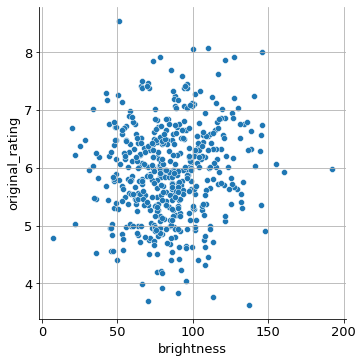

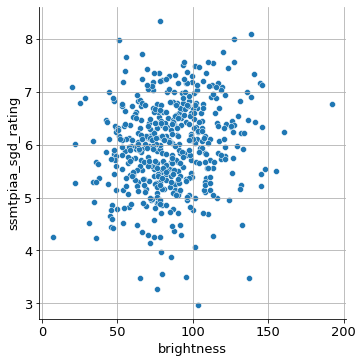

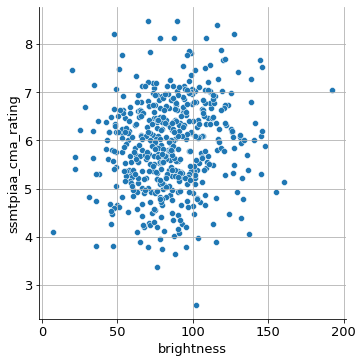

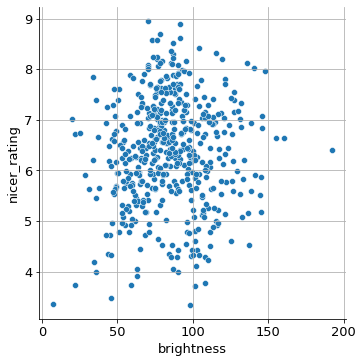

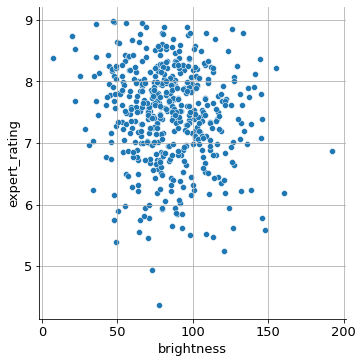

In [13]:
for style in styles_to_evaluate:
    sns.relplot(x="brightness", y=f'{style}_rating', data=image_brightness)
    plt.grid()
    plt.show()

## Somewhat inconclusive results, lets plot means for intervals of 10

In [14]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

mean_ratings = {'meanrating': [], 'style': [], 'brightness': []}

mean_ratings_orig = {'meanrating': [], 'style': [], 'brightness': []}

mean_ssims = {'ssim': [], 'style': [], 'brightness': []}

if 'original' in styles_to_evaluate:
    styles_to_evaluate.remove('original')

similarity_to_orig = pd.read_csv(Path('sets/survey_similarities.csv'))
similarity_to_orig.drop(columns=['original', 'Unnamed: 0'], inplace=True)

data = pd.concat([image_brightness, similarity_to_orig], axis=1)

i = 40
step_size = 10
while i < 145:
    rows = data.loc[(data['brightness'] >= i) & (data['brightness'] < i+step_size)]
    original = np.mean(rows[f'original_rating'])
    mean_ratings_orig['meanrating'].append(original)
    mean_ratings_orig['style'].append('Original')
    mean_ratings_orig['brightness'].append(i)
    for style in styles_to_evaluate:
        mean_ratings['meanrating'].append(np.mean(rows[f'{style}_rating'])-original)
        mean_ratings['brightness'].append(i)
        if style == 'original':
            mean_ratings['style'].append('Original')
        elif style == 'ssmtpiaa_sgd':
            mean_ratings['style'].append('Ours(SGD)')
        elif style == 'ssmtpiaa_cma':
            mean_ratings['style'].append('Ours(CMA)')
        elif style == 'nicer':
            mean_ratings['style'].append('NICER')
        else:
            mean_ratings['style'].append('Expert')

        mean_ssims['ssim'].append(np.mean(rows[style]))
        mean_ssims['brightness'].append(i)
        if style == 'original':
            mean_ssims['style'].append('Original')
        elif style == 'ssmtpiaa_sgd':
            mean_ssims['style'].append('Ours(SGD)')
        elif style == 'ssmtpiaa_cma':
            mean_ssims['style'].append('Ours(CMA)')
        elif style == 'nicer':
            mean_ssims['style'].append('NICER')
        else:
            mean_ssims['style'].append('Expert')
    i+=step_size

mean_ratings = pd.DataFrame(mean_ratings)

mean_ratings_orig = pd.DataFrame(mean_ratings_orig)


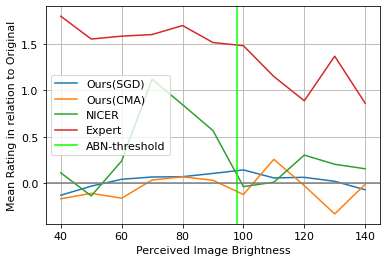

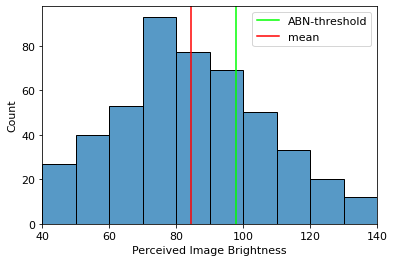

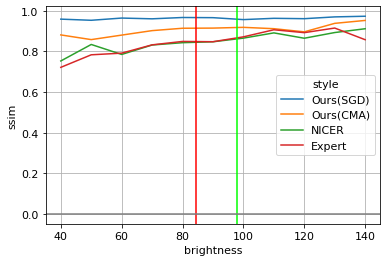

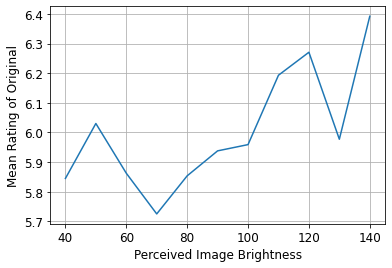

In [15]:
out = plotpath / 'brightness'

g = sns.lineplot(x="brightness", y=f'meanrating', hue='style', data=mean_ratings)
#plt.axvline(np.mean(image_brightness['brightness']), color='red', label='mean brightness')
plt.axvline(98, color='lime', label='ABN-threshold')
plt.axhline(y=0.0, color='grey', linestyle='-')
plt.grid()
plt.legend()
g.set(xlabel="Perceived Image Brightness",
      ylabel="Mean Rating in relation to Original")

plt.savefig(out / 'brightrating.svg')
plt.show()

g = sns.histplot(x="brightness", data=image_brightness, bins=[40,50,60,70,80,90,100,110,120,130,140])
plt.axvline(98, color='lime', label='ABN-threshold')
plt.axvline(158, color='lime')
plt.axvline(np.mean(image_brightness['brightness']), color='red', label='mean')
plt.xlim(40,140)
plt.legend()
g.set(xlabel="Perceived Image Brightness")
plt.savefig(out / 'brightdist.svg')
plt.show()

g = sns.lineplot(x="brightness", y=f'ssim', hue='style', data=mean_ssims)
plt.axvline(np.mean(image_brightness['brightness']), color='red', label='mean brightness')
plt.axvline(98, color='lime', label='ABN-threshold')
plt.axhline(y=0.0, color='grey', linestyle='-')
plt.grid()
plt.show()
plt.close()

matplotlib.rcParams.update({'font.size': 12})

g = sns.lineplot(x="brightness", y=f'meanrating', data=mean_ratings_orig)
#plt.axvline(np.mean(image_brightness['brightness']), color='red', label='mean brightness')
plt.grid()
g.set(xlabel="Perceived Image Brightness",
      ylabel="Mean Rating of Original")

plt.savefig(out / 'origrating.svg')
plt.show()

matplotlib.rcParams.update({'font.size': 11})

## How do thigs look when excluding dark P<98 images?

In [16]:
no_ABN = image_brightness[image_brightness['brightness'] >= 98]
no_ABN = no_ABN[no_ABN['brightness'] <= 158]
images = no_ABN['image_id'].tolist()
survey_result_no_ABN = survey_result[survey_result['image_id'].isin(images)]
survey_result_no_ABN.reset_index(inplace=True, drop=True)

display(survey_result_no_ABN)

print(len(images))
print(survey_result_no_ABN.shape[0])

,worker,duration,image_id,ssmtpiaa_sgd_rating,ssmtpiaa_sgd_img_link,ssmtpiaa_sgd_img,nicer_rating,nicer_img_link,nicer_img,ssmtpiaa_cma_rating,ssmtpiaa_cma_img_link,ssmtpiaa_cma_img,expert_rating,expert_img_link,expert_img,original_rating,original_img_link,original_img
0,A41IPBF6AJGI9,200,16,7.5,ssmtpiaa_sgd/fivek-16_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.0,nicer/fivek-16_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",6.8,ssmtpiaa_cma/fivek-16_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.0,expert/fivek-16_expertc.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.6,original/fivek-16_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
1,A2UFVUTKGCQK8U,18,16,6.6,ssmtpiaa_sgd/fivek-16_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.5,nicer/fivek-16_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.7,ssmtpiaa_cma/fivek-16_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.2,expert/fivek-16_expertc.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.1,original/fivek-16_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
2,AI1NPS9BYF0Q1,29,16,6.6,ssmtpiaa_sgd/fivek-16_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",5.2,nicer/fivek-16_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.2,ssmtpiaa_cma/fivek-16_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.4,expert/fivek-16_expertc.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",6.1,original/fivek-16_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
3,A4D99Y82KOLC8,86,16,7.0,ssmtpiaa_sgd/fivek-16_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.8,nicer/fivek-16_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",10.0,ssmtpiaa_cma/fivek-16_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.6,expert/fivek-16_expertc.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",6.7,original/fivek-16_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
4,A1T02KY1E9YI3I,383,16,8.5,ssmtpiaa_sgd/fivek-16_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",4.8,nicer/fivek-16_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.5,ssmtpiaa_cma/fivek-16_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",9.5,expert/fivek-16_expertc.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.5,original/fivek-16_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,AOTNZ2CR4S0SL,40,4953,6.8,ssmtpiaa_sgd/fivek-4953_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.4,nicer/fivek-4953_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.0,ssmtpiaa_cma/fivek-4953_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",6.5,expert/fivek-4953_expertd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",6.4,original/fivek-4953_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
1260,A23BGNP50WTKI2,33,4953,5.2,ssmtpiaa_sgd/fivek-4953_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",3.4,nicer/fivek-4953_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.7,ssmtpiaa_cma/fivek-4953_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.4,expert/fivek-4953_expertd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",3.9,original/fivek-4953_original.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k..."
1261,A3VC2ZAJP08NYJ,3479,4953,7.2,ssmtpiaa_sgd/fivek-4953_ssmtpiaa_sgd.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.6,nicer/fivek-4953_nicer.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",7.7,ssmtpiaa_cma/fivek-4953_ssmtpiaa_cma.jpg,"<img src=""https://vps.pfstr.de/f/mturk/adobe5k...",8.6,expert/fivek-4953_exp

136
1264


In [17]:
styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))

best_count = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)
best_percent = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

for pair in pairs_to_evaluate:
    best_counted = utils.count_best(survey_result_no_ABN, pair, visualization=False)
    best_count.at[pair[0], pair[1]] = best_counted[pair[0]]
    best_count.at[pair[1], pair[0]] = best_counted[pair[1]]
    best_percent.at[pair[0], pair[1]] = best_counted[pair[0]] / (best_counted[pair[0]] + best_counted[pair[1]])
    best_percent.at[pair[1], pair[0]] = best_counted[pair[1]] / (best_counted[pair[0]] + best_counted[pair[1]])

#best_count.prefered_in = best_count.prefered_in.astype(int)
display(best_count)
display(best_percent)

print(best_count.to_latex())

,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,616,574,623,373
nicer,621,NaN,622,650,429
ssmtpiaa_sgd,650,617,NaN,648,390
ssmtpiaa_cma,609,590,582,NaN,398
expert,864,813,849,847,NaN


,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,0.497979,0.468954,0.505682,0.301536
nicer,0.502021,NaN,0.502018,0.524194,0.345411
ssmtpiaa_sgd,0.531046,0.497982,NaN,0.526829,0.31477
ssmtpiaa_cma,0.494318,0.475806,0.473171,NaN,0.319679
expert,0.698464,0.654589,0.68523,0.680321,NaN


\begin{tabular}{llllll}
\toprule
{} & original & nicer & ssmtpiaa\_sgd & ssmtpiaa\_cma & expert \\
\midrule
original     &      NaN &   616 &          574 &          623 &    373 \\
nicer        &      621 &   NaN &          622 &          650 &    429 \\
ssmtpiaa\_sgd &      650 &   617 &          NaN &          648 &    390 \\
ssmtpiaa\_cma &      609 &   590 &          582 &          NaN &    398 \\
expert       &      864 &   813 &          849 &          847 &    NaN \\
\bottomrule
\end{tabular}



In [18]:
significance_level = 0.05
n = survey_result_no_ABN.shape[0]
p = 0.5
correction = 'Sidak'

styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))
results_significance = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

m = (len(styles_to_evaluate) * len(styles_to_evaluate)) / 2 - len(styles_to_evaluate) / 2
if correction == 'Bonferroni':
    corrected_significance_level = significance_level / m
elif correction == 'Sidak':
    corrected_significance_level = 1-(1-significance_level) ** (1/m)
else:
    correction = 'Un'
    corrected_significance_level = significance_level


print(f"{correction} corrected significance level is {'{:.2%}'.format(corrected_significance_level)} with m of {m}")

for pair in pairs_to_evaluate:
    for pair_perm in itertools.permutations(pair):
        base_style, enhanced_style = pair_perm[0], pair_perm[1]
        even_correction = 0
        enhanced_is_better = []
        for i in range(survey_result_no_ABN.shape[0]):
            iter = 0
            best = 0
            # Get best rating for each image
            for style in [base_style, enhanced_style]:
                best = max(best, survey_result_no_ABN.at[i, f'{style}_rating'])
            # Find out to which style it belongs
            if survey_result_no_ABN.at[i, f'{enhanced_style}_rating'] == best:
                if not survey_result_no_ABN.at[i, f'{base_style}_rating'] == best:
                    enhanced_is_better.append(1)
                else:
                    even_correction += 1

        k = len(enhanced_is_better)
        results_significance.at[enhanced_style, base_style] = stats.binomtest(k, n-even_correction, p, alternative='greater')

display(HTML(results_significance.to_html(escape=False)))

Sidak corrected significance level is 0.51% with m of 10.0


,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,"BinomTestResult(k=616, n=1237, alternative='greater', proportion_estimate=0.49797898140662894, pvalue=0.5677245086037923)","BinomTestResult(k=574, n=1224, alternative='greater', proportion_estimate=0.46895424836601307, pvalue=0.9861488003865713)","BinomTestResult(k=623, n=1232, alternative='greater', proportion_estimate=0.5056818181818182, pvalue=0.35556077667394964)","BinomTestResult(k=373, n=1237, alternative='greater', proportion_estimate=0.301535974130962, pvalue=1.0)"
nicer,"BinomTestResult(k=621, n=1237, alternative='greater', proportion_estimate=0.502021018593371, pvalue=0.4547289055897735)",NaN,"BinomTestResult(k=622, n=1239, alternative='greater', proportion_estimate=0.5020177562550444, pvalue=0.4547652968607525)","BinomTestResult(k=650, n=1240, alternative='greater', proportion_estimate=0.5241935483870968, pvalue=0.04689936918587183)","BinomTestResult(k=429, n=1242, alternative='greater', proportion_estimate=0.34541062801932365, pvalue=1.0)"
ssmtpiaa_sgd,"BinomTestResult(k=650, n=1224, alternative='greater', proportion_estimate=0.5310457516339869, pvalue=0.01600612203735906)","BinomTestResult(k=617, n=1239, alternative='greater', proportion_estimate=0.4979822437449556, pvalue=0.567670360498824)",NaN,"BinomTestResult(k=648, n=1230, alternative='greater', proportion_estimate=0.526829268292683, pvalue=0.031893172571847546)","BinomTestResult(k=390, n=1239, alternative='greater', proportion_estimate=0.31476997578692495, pvalue=1.0)"
ssmtpiaa_cma,"BinomTestResult(k=609, n=1232, alternative='greater', proportion_estimate=0.4943181818181818, pvalue=0.6654299614970938)","BinomTestResult(k=590, n=1240, alternative='greater', proportion_estimate=0.47580645161290325, pvalue=0.9584091902237046)","BinomTestResult(k=582, n=1230, alternative='greater', proportion_estimate=0.47317073170731705, pvalue=0.9719806216639216)",NaN,"BinomTestResult(k=398, n=1245, alternative='greater', proportion_estimate=0.3196787148594378, pvalue=1.0)"
expert,"BinomTestResult(k=864, n=1237, alternative='greater', proportion_estimate=0.698464025869038, pvalue=1.3456327341887292e-45)","BinomTestResult(k=813, n=1242, alternative='greater', proportion_estimate=0.6545893719806763, pvalue=3.1035541445523458e-28)","BinomTestResult(k=849, n=1239, alternative='greater', proportion_estimate=0.6852300242130751, pvalue=6.8268976531183015e-40)","BinomTestResult(k=847, n=1245, alternative='greater', proportion_estimate=0.6803212851405622, pvalue=4.911831707788669e-38)",NaN


In [19]:
styles = ['original', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'nicer', 'expert']

for style in styles:
    ratings.at[style, 'mean_rating'] = np.mean(survey_result_no_ABN[f'{style}_rating'])
    ratings.at[style, 'variance'] = np.var(survey_result_no_ABN[f'{style}_rating'])
    ratings.at[style, 'standard deviation'] = np.std(survey_result_no_ABN[f'{style}_rating'])

display(ratings)

print(ratings.to_latex())

,mean_rating,variance,standard deviation
original,6.101503,4.478613,2.116273
nicer,6.151028,5.510806,2.347511
ssmtpiaa_sgd,6.169146,4.443067,2.107858
ssmtpiaa_cma,6.115427,4.940482,2.222719
expert,7.345491,3.915106,1.978663


\begin{tabular}{lrrr}
\toprule
{} &  mean\_rating &  variance &  standard deviation \\
\midrule
original     &     6.101503 &  4.478613 &            2.116273 \\
nicer        &     6.151028 &  5.510806 &            2.347511 \\
ssmtpiaa\_sgd &     6.169146 &  4.443067 &            2.107858 \\
ssmtpiaa\_cma &     6.115427 &  4.940482 &            2.222719 \\
expert       &     7.345491 &  3.915106 &            1.978663 \\
\bottomrule
\end{tabular}



In [20]:
significance_level = 0.05
n = survey_result.shape[0]
styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))
results_wilcoxon = pd.DataFrame(index=styles_to_evaluate, columns=styles_to_evaluate)

m = (len(styles_to_evaluate) * len(styles_to_evaluate)) / 2 - len(styles_to_evaluate) / 2
if correction == 'Bonferroni':
    corrected_significance_level = significance_level / m
elif correction == 'Sidak':
    corrected_significance_level = 1-(1-significance_level) ** (1/m)
else:
    correction = 'Un'
    corrected_significance_level = significance_level


print(f"{correction} corrected significance level is {'{:.2%}'.format(corrected_significance_level)} with m of {m}")

for pair in pairs_to_evaluate:
    for pair_perm in itertools.permutations(pair):
        base_style, enhanced_style = pair_perm[0], pair_perm[1]

        x = survey_result_no_ABN[f'{enhanced_style}_rating']
        y = survey_result_no_ABN[f'{base_style}_rating']

        p_value = stats.wilcoxon(x, y, alternative='greater')[1]
        results_wilcoxon.at[enhanced_style, base_style] = f'{"{:.2%}".format(p_value)} {p_value < significance_level / m}'

print(f"Read: p-value of one sided Wilcoxon signed-rank test betweem [row name] and [column name], boolean indicates that H1 (greater) is assumed at " + "{:.1%}".format(significance_level)+" with correction applied")
display(HTML(results_wilcoxon.to_html(escape=False)))


Sidak corrected significance level is 0.51% with m of 10.0
Read: p-value of one sided Wilcoxon signed-rank test betweem [row name] and [column name], boolean indicates that H1 (greater) is assumed at 5.0% with correction applied


,original,nicer,ssmtpiaa_sgd,ssmtpiaa_cma,expert
original,NaN,66.56% False,98.35% False,55.87% False,100.00% False
nicer,33.44% False,NaN,70.79% False,23.41% False,100.00% False
ssmtpiaa_sgd,1.65% False,29.21% False,NaN,8.48% False,100.00% False
ssmtpiaa_cma,44.13% False,76.59% False,91.52% False,NaN,100.00% False
expert,0.00% True,0.00% True,0.00% True,0.00% True,NaN


## Does Improvement Correlate with rating on original image?

{'original_rating': [], 'ssmtpiaa_sgd_relative_rating': [], 'ssmtpiaa_cma_relative_rating': [], 'nicer_relative_rating': [], 'expert_relative_rating': []}


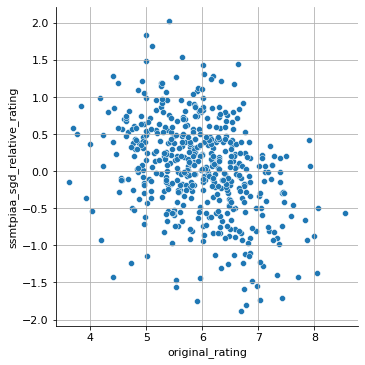

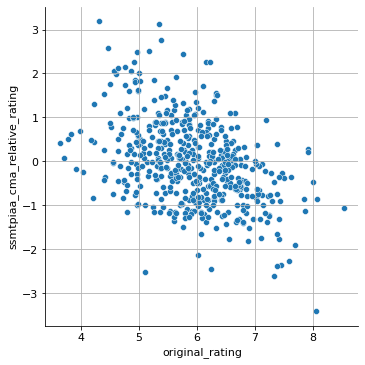

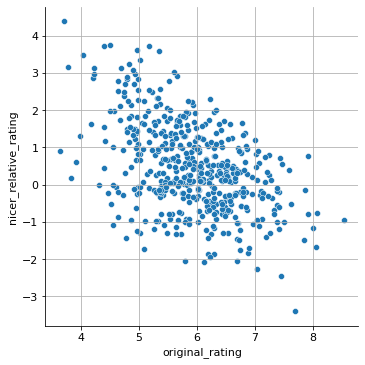

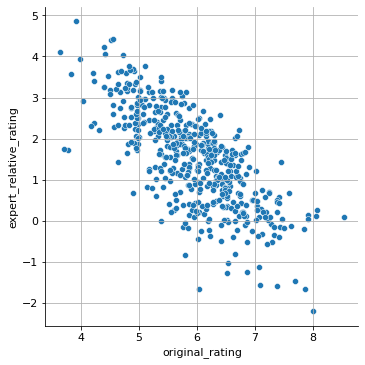

In [21]:
styles_to_evaluate = styles
styles_to_evaluate.remove('original')

relative_ratings = {'original_rating': []}

for style in styles_to_evaluate:
    relative_ratings[f"{style}_relative_rating"] = []

print(relative_ratings)

for i in range(survey_grouped.shape[0]):
    relative_ratings['original_rating'].append(survey_grouped.at[i, 'original_rating'])
    for style in styles_to_evaluate:
        relative_ratings[f"{style}_relative_rating"].append(survey_grouped.at[i, f'{style}_rating'] - survey_grouped.at[i, 'original_rating'])

relative_ratings = pd.DataFrame(relative_ratings)

for style in styles_to_evaluate:
    sns.relplot(x="original_rating", y=f'{style}_relative_rating', data=relative_ratings)
    plt.grid()
    plt.show()

## How conservative were the edits of the methods?

,mean_ssim,variance,standard deviation
ssmtpiaa_sgd,0.962159,0.000618,0.024857
ssmtpiaa_cma,0.899833,0.010195,0.100971
nicer,0.835106,0.021868,0.147879
expert,0.831997,0.010931,0.104551


ssmtpiaa_sgd has a mean SSIM to original of 0.962159159583307
ssmtpiaa_sgd has a median SSIM to original of 0.9660726890588696
ssmtpiaa_cma has a mean SSIM to original of 0.8998326623133571
ssmtpiaa_cma has a median SSIM to original of 0.9284867827129678
nicer has a mean SSIM to original of 0.8351055758077925
nicer has a median SSIM to original of 0.8849054922714785
expert has a mean SSIM to original of 0.8319974683837995
expert has a median SSIM to original of 0.8585195731745365


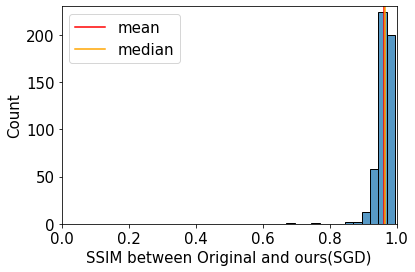

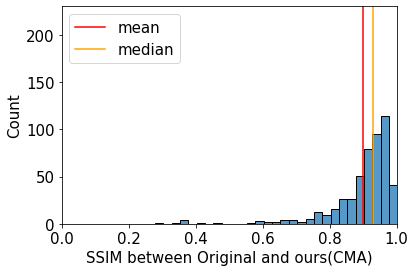

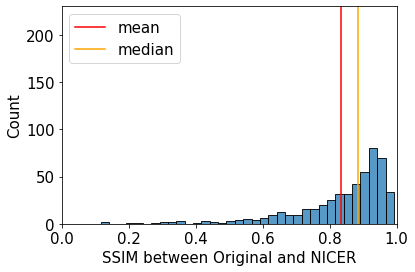

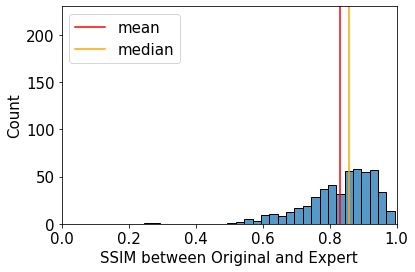

In [22]:
matplotlib.rcParams.update({'font.size': 15})

similarity_to_orig = pd.read_csv(Path('sets/survey_similarities.csv'))
similarity_to_orig.drop(columns=['original'], inplace=True)

styles_to_evaluate = ['ssmtpiaa_sgd', 'ssmtpiaa_cma', 'nicer', 'expert']

similarities = pd.DataFrame(index=styles_to_evaluate)

for style in styles_to_evaluate:
    similarities.at[style, 'mean_ssim'] = np.mean(similarity_to_orig[style])
    similarities.at[style, 'variance'] = np.var(similarity_to_orig[style])
    similarities.at[style, 'standard deviation'] = np.std(similarity_to_orig[style])

display(similarities)

out = plotpath / 'distributionSSIM'

for style in styles_to_evaluate:
    g = sns.histplot(x=style, data=similarity_to_orig, binwidth=0.025)
    plt.xlim(0, 1)
    plt.ylim(0, 230)
    plt.axvline(np.mean(similarity_to_orig[style]), color='red', label='mean')
    plt.axvline(np.median(similarity_to_orig[style]), color='orange', label='median')
    plt.legend()

    if style == 'ssmtpiaa_sgd':
        g.set(xlabel="SSIM between Original and ours(SGD)")
        plt.savefig(out / 'SGDSSIM.svg')
    if style == 'ssmtpiaa_cma':
        g.set(xlabel="SSIM between Original and ours(CMA)")
        plt.savefig(out / 'CMASSIM.svg')
    if style == 'nicer':
        g.set(xlabel="SSIM between Original and NICER")
        plt.savefig(out / 'NICERSSIM.svg')
    if style == 'expert':
        g.set(xlabel="SSIM between Original and Expert")
        plt.savefig(out / 'ExpertSSIM.svg')
    print(f"{style} has a mean SSIM to original of {np.mean(similarity_to_orig[style])}")
    print(f"{style} has a median SSIM to original of {np.median(similarity_to_orig[style])}")

    plt.show()

## Does SSIM correlate with rating increase?

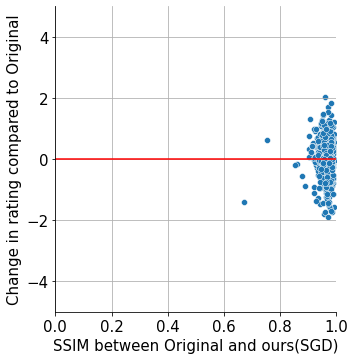

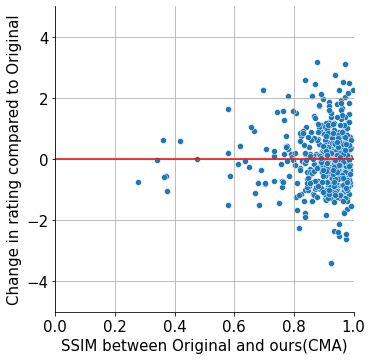

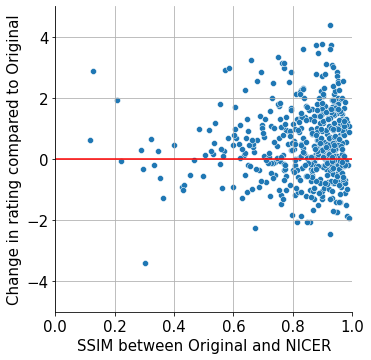

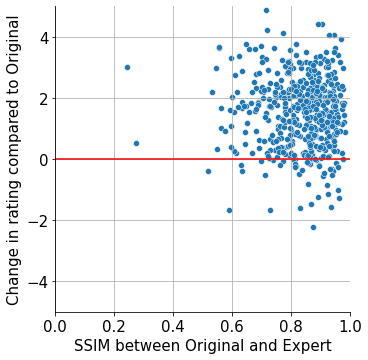

277
0
0.884%
1.274%


In [23]:
ssim_rating = pd.concat([relative_ratings,similarity_to_orig], axis=1)

styles_to_evaluate = ['ssmtpiaa_sgd', 'ssmtpiaa_cma', 'nicer', 'expert']

matplotlib.rcParams.update({'font.size': 15})

out = plotpath / 'ratingSSIM'

for style in styles_to_evaluate:
    g = sns.relplot(x=style, y=f'{style}_relative_rating', data=ssim_rating)
    plt.grid()
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.xlim(0, 1)
    plt.ylim(-5,5)
    g.set(ylabel="Change in rating compared to Original")

    if style == 'ssmtpiaa_sgd':
        g.set(xlabel="SSIM between Original and ours(SGD)")
        plt.savefig(out / 'SGDrating.svg')
    if style == 'ssmtpiaa_cma':
        g.set(xlabel="SSIM between Original and ours(CMA)")
        plt.savefig(out / 'CMArating.svg')
    if style == 'nicer':
        g.set(xlabel="SSIM between Original and NICER")
        plt.savefig(out / 'NICERrating.svg')
    if style == 'expert':
        g.set(xlabel="SSIM between Original and Expert")
        plt.savefig(out / 'Expertrating.svg')

    plt.show()

ssim_rating_imp_sgd=ssim_rating[ssim_rating[f'ssmtpiaa_sgd_relative_rating'] > 0]

print(ssim_rating_imp_sgd.shape[0])
k = ssim_rating_imp_sgd.shape[0]
ssim_rating_imp_sgd=ssim_rating[ssim_rating[f'ssmtpiaa_sgd_relative_rating'] == 0]

print(ssim_rating_imp_sgd.shape[0])

p=0.5
significance_level=0.05

print("{:.3%}".format(scipy.stats.binomtest(k, 500, p, alternative='greater').pvalue))

m = 4
print("{:.3%}".format(1-(1-significance_level) ** (1/m)))

## Pairwise comparion of SSIM between methods

In [24]:
import ast

styles_to_evaluate = ['original', 'nicer', 'ssmtpiaa_sgd', 'ssmtpiaa_cma', 'expert']
pairs_to_evaluate = list(itertools.combinations(styles_to_evaluate, 2))

paiwise_ssim_lists = pd.read_csv(Path('sets/survey_similarities_pairwise.csv'), index_col=0)

for col in paiwise_ssim_lists.columns:
    for row in paiwise_ssim_lists.index:
        paiwise_ssim_lists.at[col,row] = ast.literal_eval(paiwise_ssim_lists.at[col,row])

paiwise_avg_ssim = pd.DataFrame(index=paiwise_ssim_lists.index, columns=paiwise_ssim_lists.columns)

for pair in pairs_to_evaluate:
    for pair_perm in itertools.permutations(pair):
        base_style, enhanced_style = pair_perm[0], pair_perm[1]
        paiwise_avg_ssim.at[pair_perm[0], pair_perm[1]] = "{:.3f}".format(np.mean(paiwise_ssim_lists.at[pair_perm[0], pair_perm[1]]))

print(paiwise_avg_ssim.to_latex())

display(paiwise_avg_ssim)

\begin{tabular}{llllll}
\toprule
{} & original & ssmtpiaa\_sgd & ssmtpiaa\_cma &  nicer & expert \\
\midrule
original     &      NaN &        0.962 &        0.900 &  0.835 &  0.832 \\
ssmtpiaa\_sgd &    0.962 &          NaN &        0.915 &  0.842 &  0.811 \\
ssmtpiaa\_cma &    0.900 &        0.915 &          NaN &  0.808 &  0.778 \\
nicer        &    0.835 &        0.842 &        0.808 &    NaN &  0.768 \\
expert       &    0.832 &        0.811 &        0.778 &  0.768 &    NaN \\
\bottomrule
\end{tabular}



,original,ssmtpiaa_sgd,ssmtpiaa_cma,nicer,expert
original,NaN,0.962,0.900,0.835,0.832
ssmtpiaa_sgd,0.962,NaN,0.915,0.842,0.811
ssmtpiaa_cma,0.900,0.915,NaN,0.808,0.778
nicer,0.835,0.842,0.808,NaN,0.768
expert,0.832,0.811,0.778,0.768,NaN
